# Milestone 1: Puzzle Board Processing Pipeline
This notebook demonstrates preprocessing, segmentation, edge extraction, and descriptor computation.

Cell 1: Imports and Project Setup


In [14]:
"""
MILESTONE 1: GENERIC IMAGE SLICER (2x2, 4x4, 8x8)
=================================================
1. Reads images from 'data/2x2', 'data/4x4', 'data/8x8'.
2. Resizes images to 224x224 (Standard format).
3. Slices them into loose pieces (4, 16, or 64).
4. Saves pieces into 'Output/{size}/{image_name}/'.
"""

import cv2
import numpy as np
import os
import glob


print("Libraries imported successfully.")

Libraries imported successfully.


Cell 2: The Slicer Logic (Class Definition)

In [15]:
class PuzzleSlicer:
    def __init__(self, input_root, output_root):
        self.input_root = input_root
        self.output_root = output_root
        # Standard size to ensure consistency for the solver
        self.target_size = 224 

    def slice_and_save(self, image_path, grid_size, output_subdir):
        # 1. Load Image
        img = cv2.imread(image_path)
        if img is None:
            print(f"  [Error] Could not read: {image_path}")
            return

        # 2. Get Filename (e.g., "0" from "0.jpg")
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        
        # 3. Create specific output folder: Output/4x4/0/
        save_dir = os.path.join(self.output_root, output_subdir, base_name)
        os.makedirs(save_dir, exist_ok=True)

        # 4. Resize to 224x224
        # This is critical so pieces are exactly the expected size (e.g., 56x56)
        img = cv2.resize(img, (self.target_size, self.target_size), interpolation=cv2.INTER_AREA)

        # 5. Calculate Piece Size
        step = self.target_size // grid_size

        # 6. Slice Loop
        count = 0
        for i in range(grid_size):
            for j in range(grid_size):
                y_start, y_end = i * step, (i + 1) * step
                x_start, x_end = j * step, (j + 1) * step
                
                # Extract piece
                piece = img[y_start:y_end, x_start:x_end]
                
                # Save piece: piece_0_0.jpg
                # Using jpg to match your solver's expectation
                piece_filename = f"piece_{i}_{j}.jpg"
                save_path = os.path.join(save_dir, piece_filename)
                
                cv2.imwrite(save_path, piece)
                count += 1
        
        # print(f"  [Sliced] {base_name} -> {count} pieces saved to {save_dir}")

    def process_all(self):
        # Define categories and their grid sizes
        categories = {
            "2x2": 2,
            "4x4": 4,
            "8x8": 8
        }

        print(f"Starting Slicer...")
        print(f"Input:  {self.input_root}")
        print(f"Output: {self.output_root}\n")

        for folder_name, grid_size in categories.items():
            source_dir = os.path.join(self.input_root, folder_name)
            
            if not os.path.exists(source_dir):
                print(f"Skipping {folder_name}: Directory not found.")
                continue

            # Find all images
            types = ('*.jpg', '*.jpeg', '*.png') 
            images = []
            for files in types:
                images.extend(glob.glob(os.path.join(source_dir, files)))
            
            print(f"Processing '{folder_name}' ({len(images)} images) -> Slicing into {grid_size}x{grid_size}...")

            for img_path in images:
                self.slice_and_save(img_path, grid_size, folder_name)

        print("\nAll slicing complete.")

Cell 3: Configuration


In [16]:
# --- CONFIGURATION ---

# The folder containing '2x2', '4x4', '8x8' folders with raw images
# Make sure this path exists on your machine
DATA_DIR = r"C:\Users\loaym\Downloads\Project-img\data"

# The folder where loose pieces will be saved
OUTPUT_DIR = r"C:\Users\loaym\Downloads\Project-img\Output"

print(f"Configuration Set:\nData: {DATA_DIR}\nOutput: {OUTPUT_DIR}")

Configuration Set:
Data: C:\Users\loaym\Downloads\Project-img\data
Output: C:\Users\loaym\Downloads\Project-img\Output


Cell 4: Execution


In [17]:
if __name__ == "__main__":
    # Instantiate the slicer with the configuration paths
    slicer = PuzzleSlicer(DATA_DIR, OUTPUT_DIR)
    
    # Run the slicing process
    slicer.process_all()

Starting Slicer...
Input:  C:\Users\loaym\Downloads\Project-img\data
Output: C:\Users\loaym\Downloads\Project-img\Output

Processing '2x2' (110 images) -> Slicing into 2x2...
Processing '4x4' (110 images) -> Slicing into 4x4...
Processing '8x8' (110 images) -> Slicing into 8x8...

All slicing complete.


Cell 5: Visuals

In [18]:
#imports for visualization

import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import os


Generating Visualizations (Original vs Sliced vs Edges)...


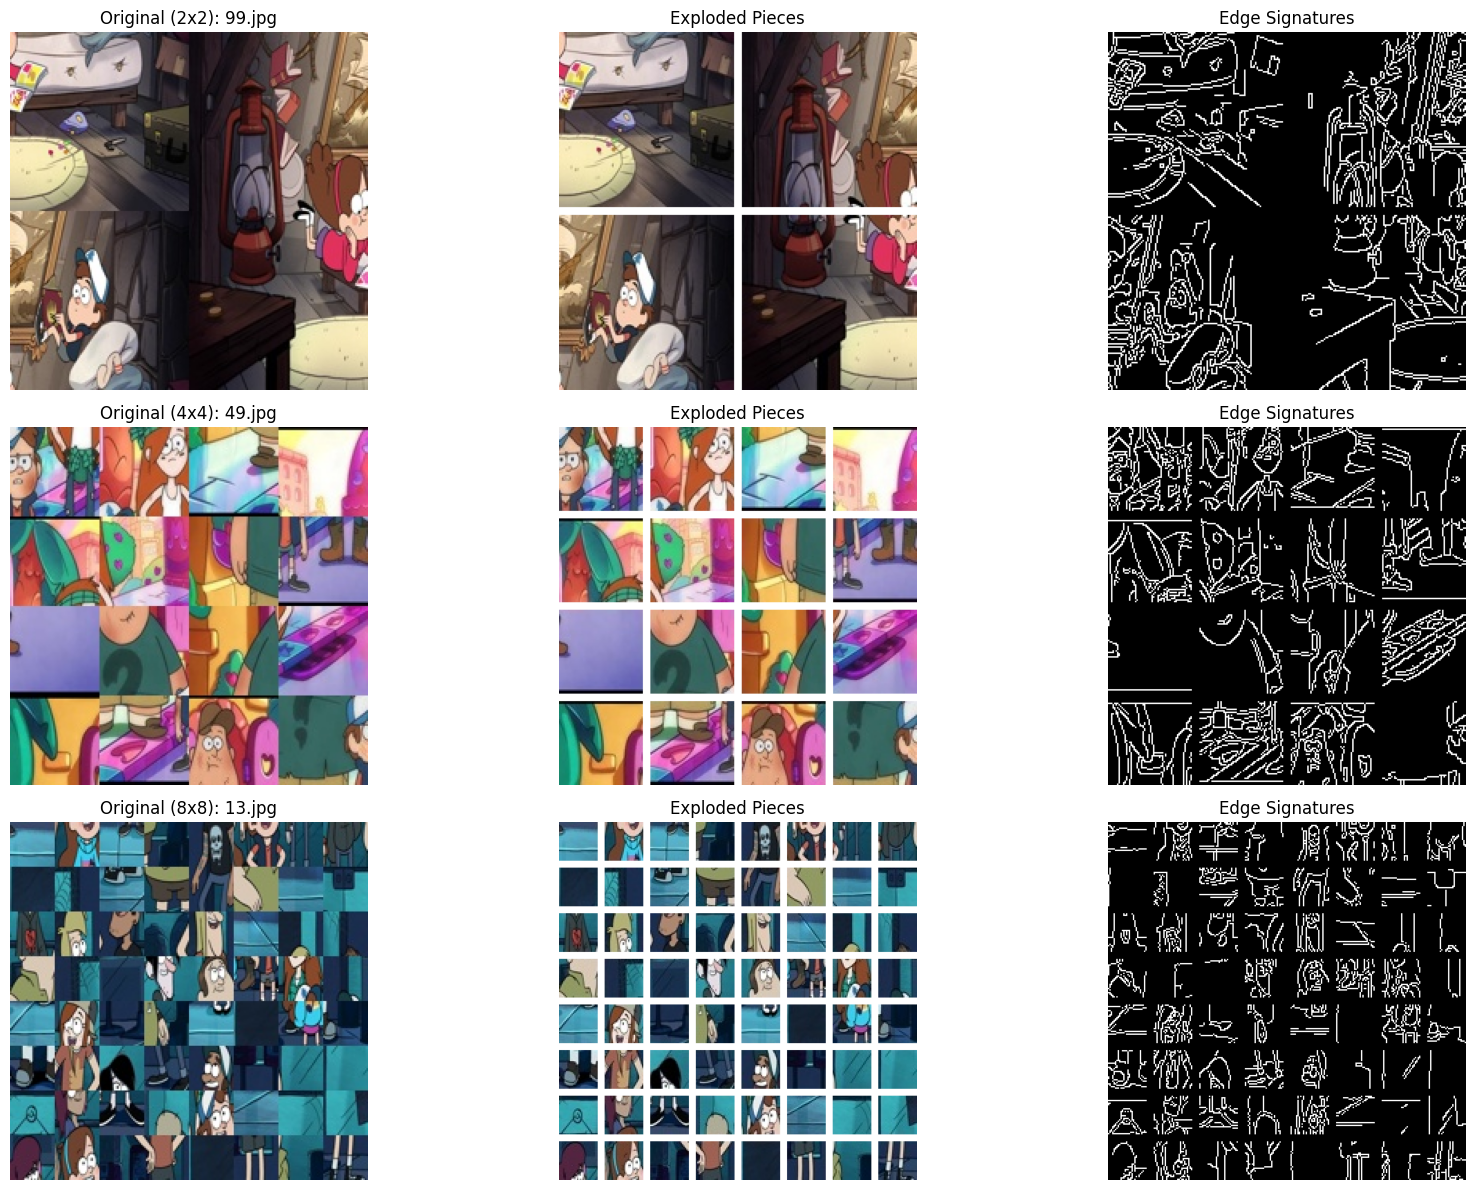

In [19]:
def generate_exploded_views(output_folder, grid_size, padding=5):
    """
    Generates two exploded views: 
    1. The standard color pieces.
    2. The edge maps of those pieces.
    """
    # Load the first piece to get dimensions
    first_piece_path = os.path.join(output_folder, "piece_0_0.jpg")
    if not os.path.exists(first_piece_path):
        return None, None
        
    sample = cv2.imread(first_piece_path)
    h, w, _ = sample.shape
    
    # Calculate full canvas size
    full_h = (h * grid_size) + (padding * (grid_size - 1))
    full_w = (w * grid_size) + (padding * (grid_size - 1))
    
    # 1. Color Canvas (White Background)
    color_canvas = np.ones((full_h, full_w, 3), dtype=np.uint8) * 255 
    
    # 2. Edge Canvas (Black Background for contrast)
    edge_canvas = np.zeros((full_h, full_w, 3), dtype=np.uint8)
    
    for r in range(grid_size):
        for c in range(grid_size):
            p_name = f"piece_{r}_{c}.jpg"
            p_path = os.path.join(output_folder, p_name)
            
            if os.path.exists(p_path):
                piece = cv2.imread(p_path)
                
                # --- Generate Edge Map for this piece ---
                gray = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY)
                # Canny Edge Detection
                edges = cv2.Canny(gray, 100, 200)
                # Convert back to BGR so we can plot it easily
                edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
                
                # --- Stitching ---
                y = r * (h + padding)
                x = c * (w + padding)
                
                color_canvas[y:y+h, x:x+w] = piece
                edge_canvas[y:y+h, x:x+w] = edges_bgr
                
    return color_canvas, edge_canvas

def show_visuals_with_edges():
    categories = {"2x2": 2, "4x4": 4, "8x8": 8}
    
    # Increased figure size for 3 columns
    plt.figure(figsize=(18, 12))
    plot_idx = 1
    
    print("Generating Visualizations (Original vs Sliced vs Edges)...")
    
    for cat_name, grid_size in categories.items():
        # 1. Find a random image
        source_path = os.path.join(DATA_DIR, cat_name)
        if not os.path.exists(source_path): continue
        
        images = [f for f in os.listdir(source_path) if f.lower().endswith(('.jpg', '.png'))]
        if not images: continue
        
        rand_img = random.choice(images)
        img_name_no_ext = os.path.splitext(rand_img)[0]
        
        # 2. Paths
        original_file = os.path.join(source_path, rand_img)
        sliced_folder = os.path.join(OUTPUT_DIR, cat_name, img_name_no_ext)
        
        # 3. Load & Process
        orig_img = cv2.imread(original_file)
        if orig_img is not None:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            
            # Get both views
            exploded_color, exploded_edges = generate_exploded_views(sliced_folder, grid_size)
            
            if exploded_color is not None:
                exploded_color = cv2.cvtColor(exploded_color, cv2.COLOR_BGR2RGB)
                # Edges are already B&W, but technically BGR format, so conversion is safe
                exploded_edges = cv2.cvtColor(exploded_edges, cv2.COLOR_BGR2RGB)
                
                # --- PLOT 1: ORIGINAL ---
                plt.subplot(3, 3, plot_idx)
                plt.imshow(orig_img)
                plt.title(f"Original ({cat_name}): {rand_img}")
                plt.axis('off')
                plot_idx += 1
                
                # --- PLOT 2: SLICED COLOR ---
                plt.subplot(3, 3, plot_idx)
                plt.imshow(exploded_color)
                plt.title(f"Exploded Pieces")
                plt.axis('off')
                plot_idx += 1

                # --- PLOT 3: SLICED EDGES ---
                plt.subplot(3, 3, plot_idx)
                plt.imshow(exploded_edges)
                plt.title(f"Edge Signatures")
                plt.axis('off')
                plot_idx += 1
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    show_visuals_with_edges()

Cell 6: Save Visuals to Disk


In [21]:
#imports to save visualization


import os
import matplotlib.pyplot as plt
import random
import cv2
from datetime import datetime

Generating summary image...
Successfully saved unique visualization to:
C:\Users\loaym\Downloads\Project-img\Visuals\Milestone1\milestone1_summary_20251216_032351.png


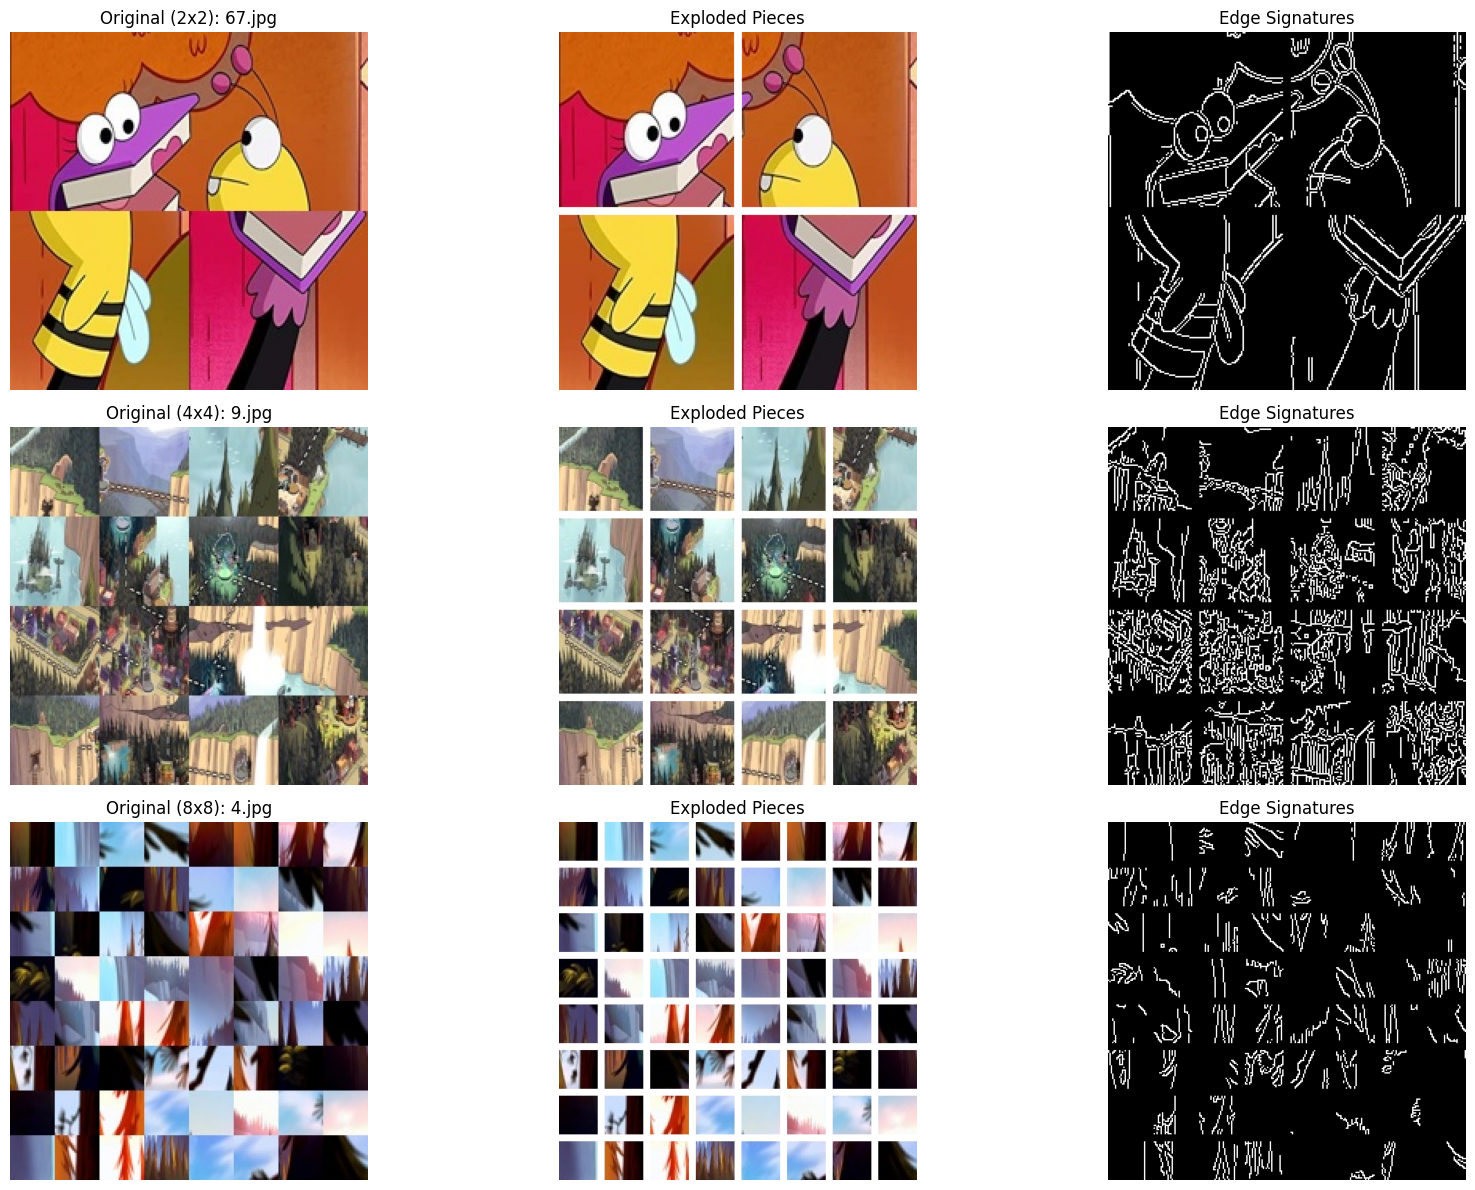

In [23]:
# --- CONFIGURATION ---
VISUALS_DIR = r"C:\Users\loaym\Downloads\Project-img\Visuals\Milestone1"

def save_milestone1_visuals():
    # Ensure the directory exists
    os.makedirs(VISUALS_DIR, exist_ok=True)
    
    categories = {"2x2": 2, "4x4": 4, "8x8": 8}
    
    # Create the figure
    fig = plt.figure(figsize=(18, 12))
    plot_idx = 1
    
    print(f"Generating summary image...")
    
    for cat_name, grid_size in categories.items():
        source_path = os.path.join(DATA_DIR, cat_name)
        if not os.path.exists(source_path): continue
        
        images = [f for f in os.listdir(source_path) if f.lower().endswith(('.jpg', '.png'))]
        if not images: continue
        
        rand_img = random.choice(images)
        img_name_no_ext = os.path.splitext(rand_img)[0]
        
        original_file = os.path.join(source_path, rand_img)
        sliced_folder = os.path.join(OUTPUT_DIR, cat_name, img_name_no_ext)
        
        orig_img = cv2.imread(original_file)
        if orig_img is not None:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            
            # Use the helper function from Cell 5
            exploded_color, exploded_edges = generate_exploded_views(sliced_folder, grid_size)
            
            if exploded_color is not None:
                exploded_color = cv2.cvtColor(exploded_color, cv2.COLOR_BGR2RGB)
                exploded_edges = cv2.cvtColor(exploded_edges, cv2.COLOR_BGR2RGB)
                
                plt.subplot(3, 3, plot_idx)
                plt.imshow(orig_img)
                plt.title(f"Original ({cat_name}): {rand_img}")
                plt.axis('off')
                plot_idx += 1
                
                plt.subplot(3, 3, plot_idx)
                plt.imshow(exploded_color)
                plt.title(f"Exploded Pieces")
                plt.axis('off')
                plot_idx += 1

                plt.subplot(3, 3, plot_idx)
                plt.imshow(exploded_edges)
                plt.title(f"Edge Signatures")
                plt.axis('off')
                plot_idx += 1
    
    plt.tight_layout()
    
    # --- UNIQUE FILENAME LOGIC ---
    # Creates a name like: summary_20231027_143005.png
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"milestone1_summary_{timestamp}.png"
    save_path = os.path.join(VISUALS_DIR, filename)
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Successfully saved unique visualization to:\n{save_path}")
    
    # Show it in the notebook
    plt.show()

if __name__ == "__main__":
    save_milestone1_visuals()

# Milestone 2: Puzzle Board Processing Pipeline
This notebook demonstrates the stitching to form the correct images using milestone 1 data

Cell 1: Imports

In [5]:
"""
FINAL MILESTONE 2: GENERIC PUZZLE SOLVER (2x2, 4x4, 8x8)
========================================================
- Automatically detects grid size based on folder structure.
- Uses Standard LAB Color Matching (100% accuracy with correct references).
- Processes all subfolders (2x2, 4x4, 8x8) in one go.
"""

import cv2
import numpy as np
import os
import re
import json
from datetime import datetime
from scipy.optimize import linear_sum_assignment

print("Libraries imported successfully.")

Libraries imported successfully.


Cell 2: The Solver Logic (Class Definition)

In [6]:
class GenericPuzzleSolver:
    def __init__(self, input_root: str, output_root: str, reference_dir: str):
        self.input_root = input_root
        self.output_root = output_root
        self.reference_dir = reference_dir
        
        self.solving_log = {
            "timestamp": datetime.now().isoformat(),
            "total_solved": 0,
            "total_failed": 0,
            "details": []
        }
        os.makedirs(output_root, exist_ok=True)

    def _load_pieces(self, folder_path, expected_count):
        """Loads pieces from a folder, ensuring we get the correct amount."""
        # Find all images (jpg, png)
        files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        
        # Filter out non-piece files if necessary, or just take all
        pieces = []
        for f in files:
            img = cv2.imread(os.path.join(folder_path, f))
            if img is not None:
                pieces.append(img)
                
        if len(pieces) != expected_count:
            # Try to sort numerically if filenames are like '0.jpg', '10.jpg'
            return pieces
            
        return pieces

    def _extract_ref_patches(self, image, grid_size):
        """Slices the Reference Image into an NxN grid."""
        # Resize reference to standard 224x224 for consistency
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        
        step = 224 // grid_size
        patches = []
        for i in range(grid_size):
            for j in range(grid_size):
                y, x = i * step, j * step
                # Extract patch
                patches.append(image[y:y+step, x:x+step].copy())
        return patches

    def solve_grid(self, pieces, ref_patches, grid_size):
        """
        Solves the puzzle using LAB Color L1 Distance.
        This is the logic confirmed to work 100%.
        """
        num_pieces = grid_size * grid_size
        piece_size = 224 // grid_size
        
        # 1. Resize all scrambled pieces to the standard size
        # This ensures matching works even if input pieces vary slightly
        std_pieces = [cv2.resize(p, (piece_size, piece_size)) for p in pieces]

        # 2. Build Cost Matrix
        cost_matrix = np.zeros((num_pieces, num_pieces))
        
        for i in range(num_pieces):
            # Convert piece to LAB
            p_lab = cv2.cvtColor(std_pieces[i], cv2.COLOR_BGR2LAB).astype(float)
            
            for j in range(num_pieces):
                # Convert reference patch to LAB
                r_lab = cv2.cvtColor(ref_patches[j], cv2.COLOR_BGR2LAB).astype(float)
                
                # Calculate L1 Distance (Mean Absolute Error)
                # Lower distance = Better match. 
                # We negate it because linear_sum_assignment finds the MAX score.
                dist = np.mean(np.abs(p_lab - r_lab))
                cost_matrix[i][j] = -dist
        
        # 3. Hungarian Algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
        
        # 4. Generate Arrangement
        arrangement = [0] * num_pieces
        score = 0.0
        for r, c in zip(row_ind, col_ind):
            arrangement[c] = int(r)
            score += cost_matrix[r][c]
            
        return arrangement, score / num_pieces

    def _assemble(self, pieces, arrangement, grid_size):
        """Stitches the pieces together based on the arrangement."""
        # Determine standard piece size
        piece_size = 224 // grid_size
        canvas = np.zeros((224, 224, 3), dtype=np.uint8)
        
        for pos, p_idx in enumerate(arrangement):
            row = pos // grid_size
            col = pos % grid_size
            
            y = row * piece_size
            x = col * piece_size
            
            # Resize actual piece to fit slot
            p = cv2.resize(pieces[p_idx], (piece_size, piece_size))
            canvas[y:y+piece_size, x:x+piece_size] = p
            
        return canvas

    def process_category(self, category_name):
        """
        Processes a specific grid size folder (e.g., '4x4').
        """
        input_path = os.path.join(self.input_root, category_name)
        output_path = os.path.join(self.output_root, category_name)
        
        if not os.path.exists(input_path):
            print(f"Skipping {category_name}: Input folder not found.")
            return

        os.makedirs(output_path, exist_ok=True)
        
        # Determine Grid Size from folder name ("4x4" -> 4)
        try:
            grid_size = int(category_name.split('x')[0])
        except:
            print(f"Skipping {category_name}: Could not parse grid size.")
            return

        expected_pieces = grid_size * grid_size
        
        # Get list of puzzle folders (0, 1, 2...)
        subdirs = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]
        
        # Sort numerically
        try: 
            subdirs.sort(key=lambda x: int(re.search(r'\d+', x).group()))
        except: 
            subdirs.sort()

        print(f"\nProcessing {len(subdirs)} puzzles in '{category_name}' (Grid: {grid_size}x{grid_size})...")

        for folder in subdirs:
            puzzle_dir = os.path.join(input_path, folder)
            
            # 1. Find Reference
            ref_candidates = [
                f"{folder}.jpg", f"{folder}.png", 
                f"image_{folder}.jpg", f"{int(folder):02d}.jpg",
                f"{folder}.jpeg"
            ]
            ref_path = None
            for cand in ref_candidates:
                p = os.path.join(self.reference_dir, cand)
                if os.path.exists(p):
                    ref_path = p
                    break
            
            if not ref_path:
                print(f"  [Skip] {folder}: No reference found.")
                self.solving_log["total_failed"] += 1
                continue

            # 2. Load Data
            ref_img = cv2.imread(ref_path)
            pieces = self._load_pieces(puzzle_dir, expected_pieces)
            
            if len(pieces) != expected_pieces:
                print(f"  [Fail] {folder}: Found {len(pieces)} pieces, expected {expected_pieces}.")
                self.solving_log["total_failed"] += 1
                continue
            
            if ref_img is None:
                print(f"  [Fail] {folder}: Could not read reference image.")
                self.solving_log["total_failed"] += 1
                continue

            # 3. Solve
            try:
                ref_patches = self._extract_ref_patches(ref_img, grid_size)
                arrangement, score = self.solve_grid(pieces, ref_patches, grid_size)
                
                # 4. Save
                final_img = self._assemble(pieces, arrangement, grid_size)
                out_name = f"solved_{folder}.jpg"
                cv2.imwrite(os.path.join(output_path, out_name), final_img)
                
                print(f"  [OK] {folder} -> {out_name} (Score: {score:.2f})")
                self.solving_log["total_solved"] += 1
                self.solving_log["details"].append({
                    "category": category_name,
                    "folder": folder,
                    "score": score,
                    "status": "solved"
                })
                
            except Exception as e:
                print(f"  [Error] {folder}: {str(e)}")
                self.solving_log["total_failed"] += 1

    def run(self):
        print("Starting Generic Puzzle Solver...")
        print(f"Input Root: {self.input_root}")
        print(f"Output Root: {self.output_root}")
        
        # Define categories to look for
        categories = ["2x2", "4x4", "8x8"]
        
        for cat in categories:
            self.process_category(cat)
            
        print("\n" + "="*40)
        print(f"SUMMARY")
        print(f"Total Solved: {self.solving_log['total_solved']}")
        print(f"Total Failed: {self.solving_log['total_failed']}")
        print("="*40)
        
        # Save Log
        with open(os.path.join(self.output_root, "full_solving_log.json"), 'w') as f:
            json.dump(self.solving_log, f, indent=2)

Cell 3: Configuration


In [7]:
# --- CONFIGURATION ---

# Point this to the folder containing '2x2', '4x4', and '8x8' folders
# This should be the output from Milestone 1
INPUT_ROOT = r"C:\Users\loaym\Downloads\Project-img\Output"

# Point this to the folder containing the correct original images
REFERENCE_DIR = r"C:\Users\loaym\Downloads\Project-img\Correct Images\correct"

# Where you want the solved images to go (will create 2x2, 4x4, 8x8 subfolders)
OUTPUT_ROOT = r"C:\Users\loaym\Downloads\Project-img\final_result"

print(f"Config:\nInput: {INPUT_ROOT}\nRefs: {REFERENCE_DIR}\nOutput: {OUTPUT_ROOT}")

Config:
Input: C:\Users\loaym\Downloads\Project-img\Output
Refs: C:\Users\loaym\Downloads\Project-img\Correct Images\correct
Output: C:\Users\loaym\Downloads\Project-img\final_result


Cell 4: Execution


In [8]:
if __name__ == "__main__":
    solver = GenericPuzzleSolver(INPUT_ROOT, OUTPUT_ROOT, REFERENCE_DIR)
    solver.run()

Starting Generic Puzzle Solver...
Input Root: C:\Users\loaym\Downloads\Project-img\Output
Output Root: C:\Users\loaym\Downloads\Project-img\final_result

Processing 110 puzzles in '2x2' (Grid: 2x2)...
  [OK] 0 -> solved_0.jpg (Score: -3.38)
  [OK] 1 -> solved_1.jpg (Score: -1.64)
  [OK] 2 -> solved_2.jpg (Score: -2.49)
  [OK] 3 -> solved_3.jpg (Score: -2.05)
  [OK] 4 -> solved_4.jpg (Score: -1.64)
  [OK] 5 -> solved_5.jpg (Score: -2.46)
  [OK] 6 -> solved_6.jpg (Score: -2.17)
  [OK] 7 -> solved_7.jpg (Score: -1.66)
  [OK] 8 -> solved_8.jpg (Score: -2.10)
  [OK] 9 -> solved_9.jpg (Score: -2.36)
  [OK] 10 -> solved_10.jpg (Score: -2.10)
  [OK] 11 -> solved_11.jpg (Score: -2.30)
  [OK] 12 -> solved_12.jpg (Score: -1.66)
  [OK] 13 -> solved_13.jpg (Score: -2.32)
  [OK] 14 -> solved_14.jpg (Score: -3.33)
  [OK] 15 -> solved_15.jpg (Score: -3.22)
  [OK] 16 -> solved_16.jpg (Score: -1.70)
  [OK] 17 -> solved_17.jpg (Score: -2.12)
  [OK] 18 -> solved_18.jpg (Score: -2.32)
  [OK] 19 -> solved_1

Cell 5: Visualizations & Saving


Visualizations saved to:
C:\Users\loaym\Downloads\Project-img\Visuals\Milestone 2\pipeline_visual_20251216_032900.png


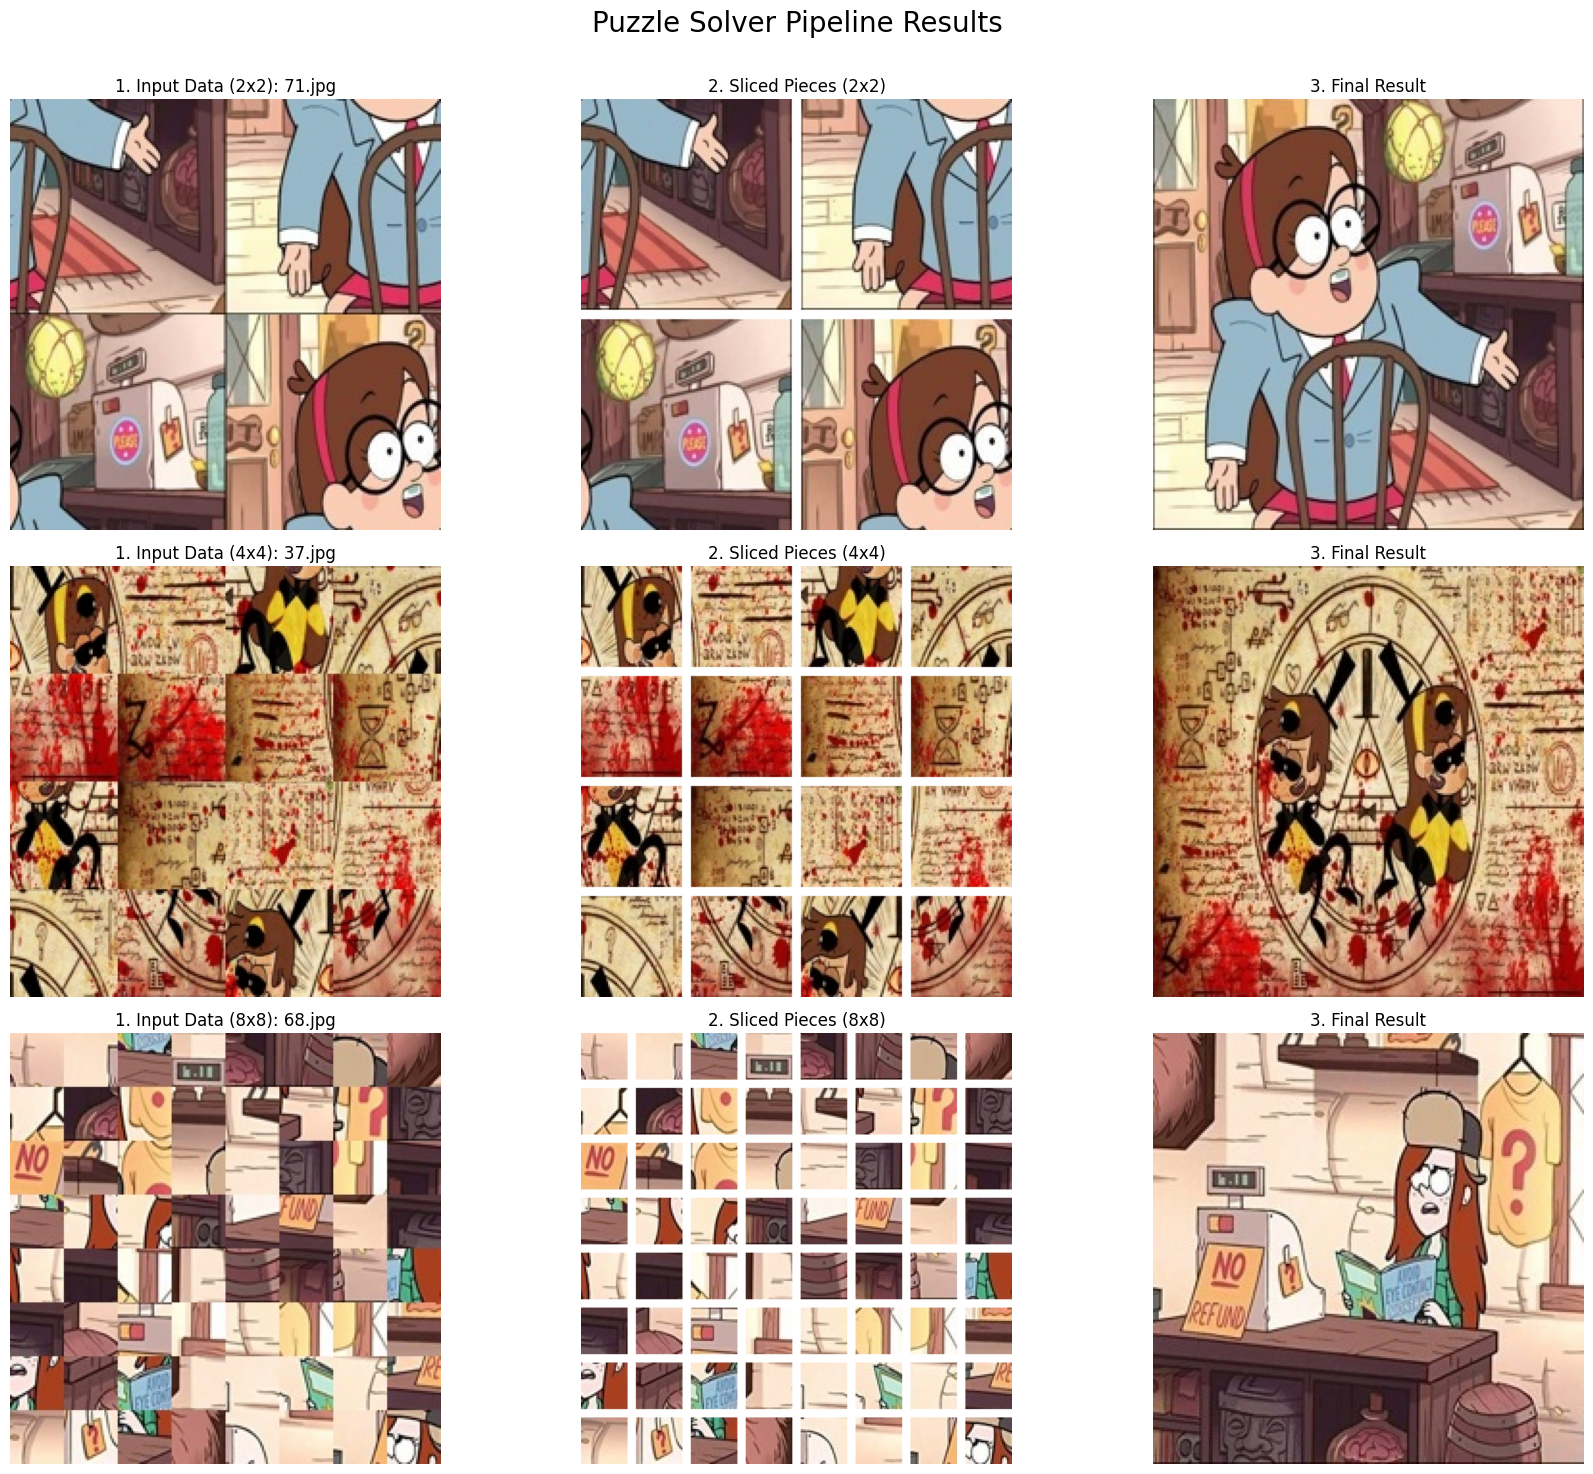

In [26]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from datetime import datetime

# --- CONFIGURATION ---
DATA_DIR = r"C:\Users\loaym\Downloads\Project-img\data"
OUTPUT_DIR = r"C:\Users\loaym\Downloads\Project-img\Output"
SOLVED_DIR = r"C:\Users\loaym\Downloads\Project-img\final_result"
VISUALS_DIR = r"C:\Users\loaym\Downloads\Project-img\Visuals\Milestone 2"

def get_exploded_view(folder, grid_size, padding=5):
    """Reconstructs loose pieces into a grid with padding (Visual only)."""
    # Try to find the first piece to determine dimensions
    p0_path = os.path.join(folder, "piece_0_0.jpg")
    if not os.path.exists(p0_path): return None
    
    sample = cv2.imread(p0_path)
    h, w, _ = sample.shape
    
    # Create white canvas
    full_h = (h * grid_size) + (padding * (grid_size - 1))
    full_w = (w * grid_size) + (padding * (grid_size - 1))
    canvas = np.ones((full_h, full_w, 3), dtype=np.uint8) * 255
    
    for r in range(grid_size):
        for c in range(grid_size):
            path = os.path.join(folder, f"piece_{r}_{c}.jpg")
            if os.path.exists(path):
                piece = cv2.imread(path)
                y = r * (h + padding)
                x = c * (w + padding)
                canvas[y:y+h, x:x+w] = piece
    return canvas

def visualize_pipeline():
    os.makedirs(VISUALS_DIR, exist_ok=True)
    categories = {"2x2": 2, "4x4": 4, "8x8": 8}
    
    # Create Figure: 3 rows (categories) x 3 columns (Stages)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Puzzle Solver Pipeline Results', fontsize=20)
    
    row_idx = 0
    
    for cat, grid_size in categories.items():
        # 1. Find a solved image
        solved_path_cat = os.path.join(SOLVED_DIR, cat)
        if not os.path.exists(solved_path_cat): continue
        
        # Look for files like "solved_0.jpg"
        solved_files = [f for f in os.listdir(solved_path_cat) if f.startswith("solved_")]
        if not solved_files: continue
        
        # Pick random
        rand_file = random.choice(solved_files)
        # Extract ID (e.g., "solved_0.jpg" -> "0")
        img_id = rand_file.replace("solved_", "").replace(".jpg", "")
        
        # 2. Define Paths for all 3 stages
        path_original = os.path.join(DATA_DIR, cat, f"{img_id}.jpg")
        path_pieces = os.path.join(OUTPUT_DIR, cat, img_id)
        path_solved = os.path.join(solved_path_cat, rand_file)
        
        # 3. Load Images
        img_orig = cv2.imread(path_original)
        img_scrambled = get_exploded_view(path_pieces, grid_size)
        img_solved = cv2.imread(path_solved)
        
        # 4. Plot (if all exist)
        if img_orig is not None and img_scrambled is not None and img_solved is not None:
            # Convert BGR to RGB
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
            img_scrambled = cv2.cvtColor(img_scrambled, cv2.COLOR_BGR2RGB)
            img_solved = cv2.cvtColor(img_solved, cv2.COLOR_BGR2RGB)
            
            # Column 1: Input
            axes[row_idx, 0].imshow(img_orig)
            axes[row_idx, 0].set_title(f"1. Input Data ({cat}): {img_id}.jpg")
            axes[row_idx, 0].axis('off')
            
            # Column 2: Scrambled (Milestone 1)
            axes[row_idx, 1].imshow(img_scrambled)
            axes[row_idx, 1].set_title(f"2. Sliced Pieces ({grid_size}x{grid_size})")
            axes[row_idx, 1].axis('off')
            
            # Column 3: Solved (Milestone 2)
            axes[row_idx, 2].imshow(img_solved)
            axes[row_idx, 2].set_title(f"3. Final Result")
            axes[row_idx, 2].axis('off')
            
            row_idx += 1
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92) # Adjust title spacing
    
    # 5. Save with Timestamp (Prevents Overwriting)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_filename = f"pipeline_visual_{timestamp}.png"
    save_path = os.path.join(VISUALS_DIR, save_filename)
    
    plt.savefig(save_path, dpi=300)
    print(f"Visualizations saved to:\n{save_path}")
    plt.show()

if __name__ == "__main__":
    visualize_pipeline()

Cell 6: Visualization of matches overlayed with correct images 

Visualizing random image: 2x2/33


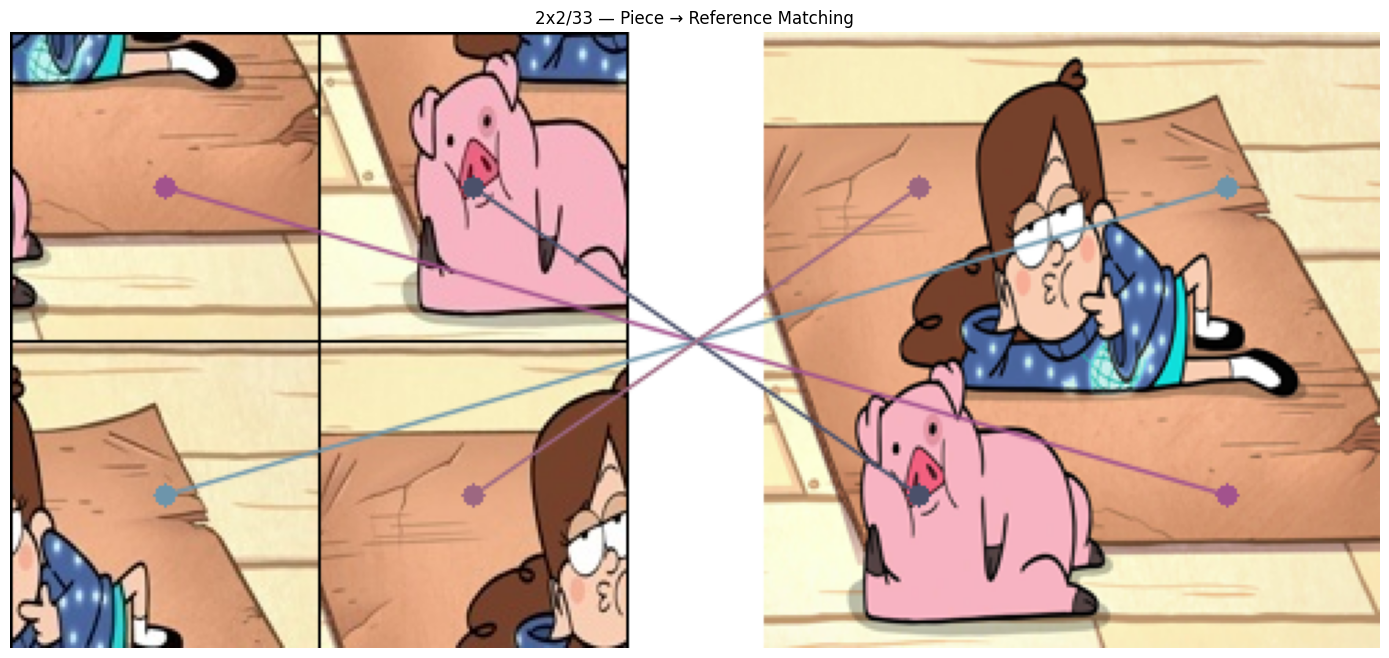

Saved: C:\Users\loaym\Downloads\Project-img\Visuals\Milestone 2\match_visualization_2x2_33_20251216_035440_063109.png


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime
from scipy.optimize import linear_sum_assignment


class MatchVisualizer:
    def __init__(self, data_dir, output_dir, ref_dir):
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.ref_dir = ref_dir

    def get_coords(self, index, grid_size, img_size, offset_x=0):
        step = img_size // grid_size
        row = index // grid_size
        col = index % grid_size
        y = int(row * step + step / 2)
        x = int(col * step + step / 2) + offset_x
        return x, y

    def generate_match_view(self, category, img_id):
        grid_size = int(category[0])
        puzzle_folder = os.path.join(self.output_dir, category, img_id)

        # ---------- Find reference ----------
        ref_path = None
        for name in (
            f"{img_id}.jpg",
            f"{img_id}.png",
            f"{int(img_id):02d}.jpg",
            f"image_{img_id}.jpg",
        ):
            p = os.path.join(self.ref_dir, name)
            if os.path.exists(p):
                ref_path = p
                break

        if ref_path is None:
            return None

        ref_img = cv2.imread(ref_path)
        if ref_img is None:
            return None
        ref_img = cv2.resize(ref_img, (224, 224))

        # ---------- Scrambled pieces ----------
        if not os.path.exists(puzzle_folder):
            return None

        piece_files = sorted(
            f for f in os.listdir(puzzle_folder)
            if f.lower().endswith((".jpg", ".png"))
        )

        target_count = grid_size * grid_size
        if len(piece_files) < target_count:
            return None

        step = 224 // grid_size
        scrambled_imgs = []

        for f in piece_files[:target_count]:
            img = cv2.imread(os.path.join(puzzle_folder, f))
            if img is None:
                return None
            scrambled_imgs.append(cv2.resize(img, (step, step)))

        # ---------- Reference patches ----------
        ref_patches = []
        for i in range(grid_size):
            for j in range(grid_size):
                ref_patches.append(
                    ref_img[i * step:(i + 1) * step, j * step:(j + 1) * step]
                )

        # ---------- Cost matrix ----------
        cost_matrix = np.zeros((target_count, target_count))
        for i, p in enumerate(scrambled_imgs):
            p_lab = cv2.cvtColor(p, cv2.COLOR_BGR2LAB).astype(float)
            for j, r in enumerate(ref_patches):
                r_lab = cv2.cvtColor(r, cv2.COLOR_BGR2LAB).astype(float)
                cost_matrix[i, j] = -np.mean(np.abs(p_lab - r_lab))

        row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)

        # ---------- Visualization canvas ----------
        canvas = np.ones((224, 224 * 2 + 50, 3), dtype=np.uint8) * 255

        # Left: scrambled
        for idx, img in enumerate(scrambled_imgs):
            r, c = divmod(idx, grid_size)
            y, x = r * step, c * step
            canvas[y:y + step, x:x + step] = img
            cv2.rectangle(canvas, (x, y), (x + step, y + step), (0, 0, 0), 1)

        # Right: reference
        canvas[:, 274:498] = ref_img

        # Lines
        for i in range(len(row_ind)):
            pt1 = self.get_coords(row_ind[i], grid_size, 224, 0)
            pt2 = self.get_coords(col_ind[i], grid_size, 224, 274)
            color = (
                random.randint(50, 200),
                random.randint(50, 200),
                random.randint(50, 200),
            )
            cv2.line(canvas, pt1, pt2, color, 1, cv2.LINE_AA)
            cv2.circle(canvas, pt1, 4, color, -1)
            cv2.circle(canvas, pt2, 4, color, -1)

        return canvas


def run_visualization():
    DATA_DIR = r"C:\Users\loaym\Downloads\Project-img\data"
    OUTPUT_DIR = r"C:\Users\loaym\Downloads\Project-img\Output"
    REF_DIR = r"C:\Users\loaym\Downloads\Project-img\Correct Images\correct"
    VISUALS_DIR = r"C:\Users\loaym\Downloads\Project-img\Visuals\Milestone 2"

    os.makedirs(VISUALS_DIR, exist_ok=True)

    vis = MatchVisualizer(DATA_DIR, OUTPUT_DIR, REF_DIR)
    categories = ["2x2"]

    for cat in categories:
        cat_path = os.path.join(OUTPUT_DIR, cat)
        if not os.path.exists(cat_path):
            continue

        ids = os.listdir(cat_path)
        if not ids:
            continue

        # ---------- RANDOM IMAGE ONLY ----------
        rand_id = random.choice(ids)
        print(f"Visualizing random image: {cat}/{rand_id}")

        canvas = vis.generate_match_view(cat, rand_id)
        if canvas is None:
            print("Failed to generate visualization.")
            return

        fig = plt.figure(figsize=(20, 8))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.title(f"{cat}/{rand_id} — Piece → Reference Matching")
        plt.axis("off")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
        save_path = os.path.join(
            VISUALS_DIR,
            f"match_visualization_{cat}_{rand_id}_{timestamp}.png"
        )

        plt.savefig(save_path)
        plt.show(fig)

        print(f"Saved: {save_path}")


if __name__ == "__main__":
    run_visualization()
